## Cell type deconvolution using MacSGP

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [4]:
RAW_PATH = "/import/home2/share/yqzeng/data/CRC" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/CRC" # Raw data
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

In [ ]:
# scRNA-seq reference data
adata_ref = sc.read_10x_h5(os.path.join(RAW_PATH, 'sc', "HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5"))
meta = pd.read_csv(os.path.join(RAW_PATH, "HumanColonCancer_VisiumHD/MetaData/SingleCell_MetaData.csv"), index_col=0)
adata_ref.obs = meta.loc[adata_ref.obs.index]

adata_ref = adata_ref[adata_ref.obs["QCFilter"] == 'Keep', :]

In [ ]:
# ST data
sample_id = "Visium_V2_Human_Colon_Cancer_P2"

adata_st = sc.read_visium(path=os.path.join(RAW_PATH, 'visium'), count_file=f"{sample_id}_filtered_feature_bc_matrix.h5")

In [6]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 26597 edges, 4269 spots.
6.230264698992738 neighbors per spot on average.


In [8]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "Level2",
                                                n_hvg_group = 150)

Finding highly variable genes...
2780 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [9]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 14/10000 [00:00<03:56, 42.24it/s]

Step: 0, Loss: -78706.5859, d_loss: -78710.9609, f_loss: 43.7775


 10%|█         | 1025/10000 [00:08<01:15, 119.54it/s]

Step: 1000, Loss: -97970.3516, d_loss: -97971.5547, f_loss: 12.0161


 20%|██        | 2017/10000 [00:17<01:07, 117.93it/s]

Step: 2000, Loss: -98133.9844, d_loss: -98135.1172, f_loss: 11.3587


 30%|███       | 3016/10000 [00:25<00:58, 118.55it/s]

Step: 3000, Loss: -98174.8828, d_loss: -98175.9844, f_loss: 11.0437


 40%|████      | 4013/10000 [00:34<00:50, 118.09it/s]

Step: 4000, Loss: -98196.4531, d_loss: -98197.5391, f_loss: 10.8741


 50%|█████     | 5024/10000 [00:42<00:42, 118.28it/s]

Step: 5000, Loss: -98208.6016, d_loss: -98209.6719, f_loss: 10.6940


 60%|██████    | 6022/10000 [00:50<00:33, 119.10it/s]

Step: 6000, Loss: -98213.4062, d_loss: -98214.4688, f_loss: 10.5979


 70%|███████   | 7022/10000 [00:59<00:24, 119.90it/s]

Step: 7000, Loss: -98225.6484, d_loss: -98226.7031, f_loss: 10.5188


 80%|████████  | 8019/10000 [01:07<00:16, 118.36it/s]

Step: 8000, Loss: -98230.4062, d_loss: -98231.4531, f_loss: 10.4472


 90%|█████████ | 9017/10000 [01:16<00:08, 118.64it/s]

Step: 9000, Loss: -98234.3906, d_loss: -98235.4297, f_loss: 10.3891


100%|██████████| 10000/10000 [01:24<00:00, 118.53it/s]


In [10]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "visium.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "visium_basis.h5ad"))

Dropping cell types: []


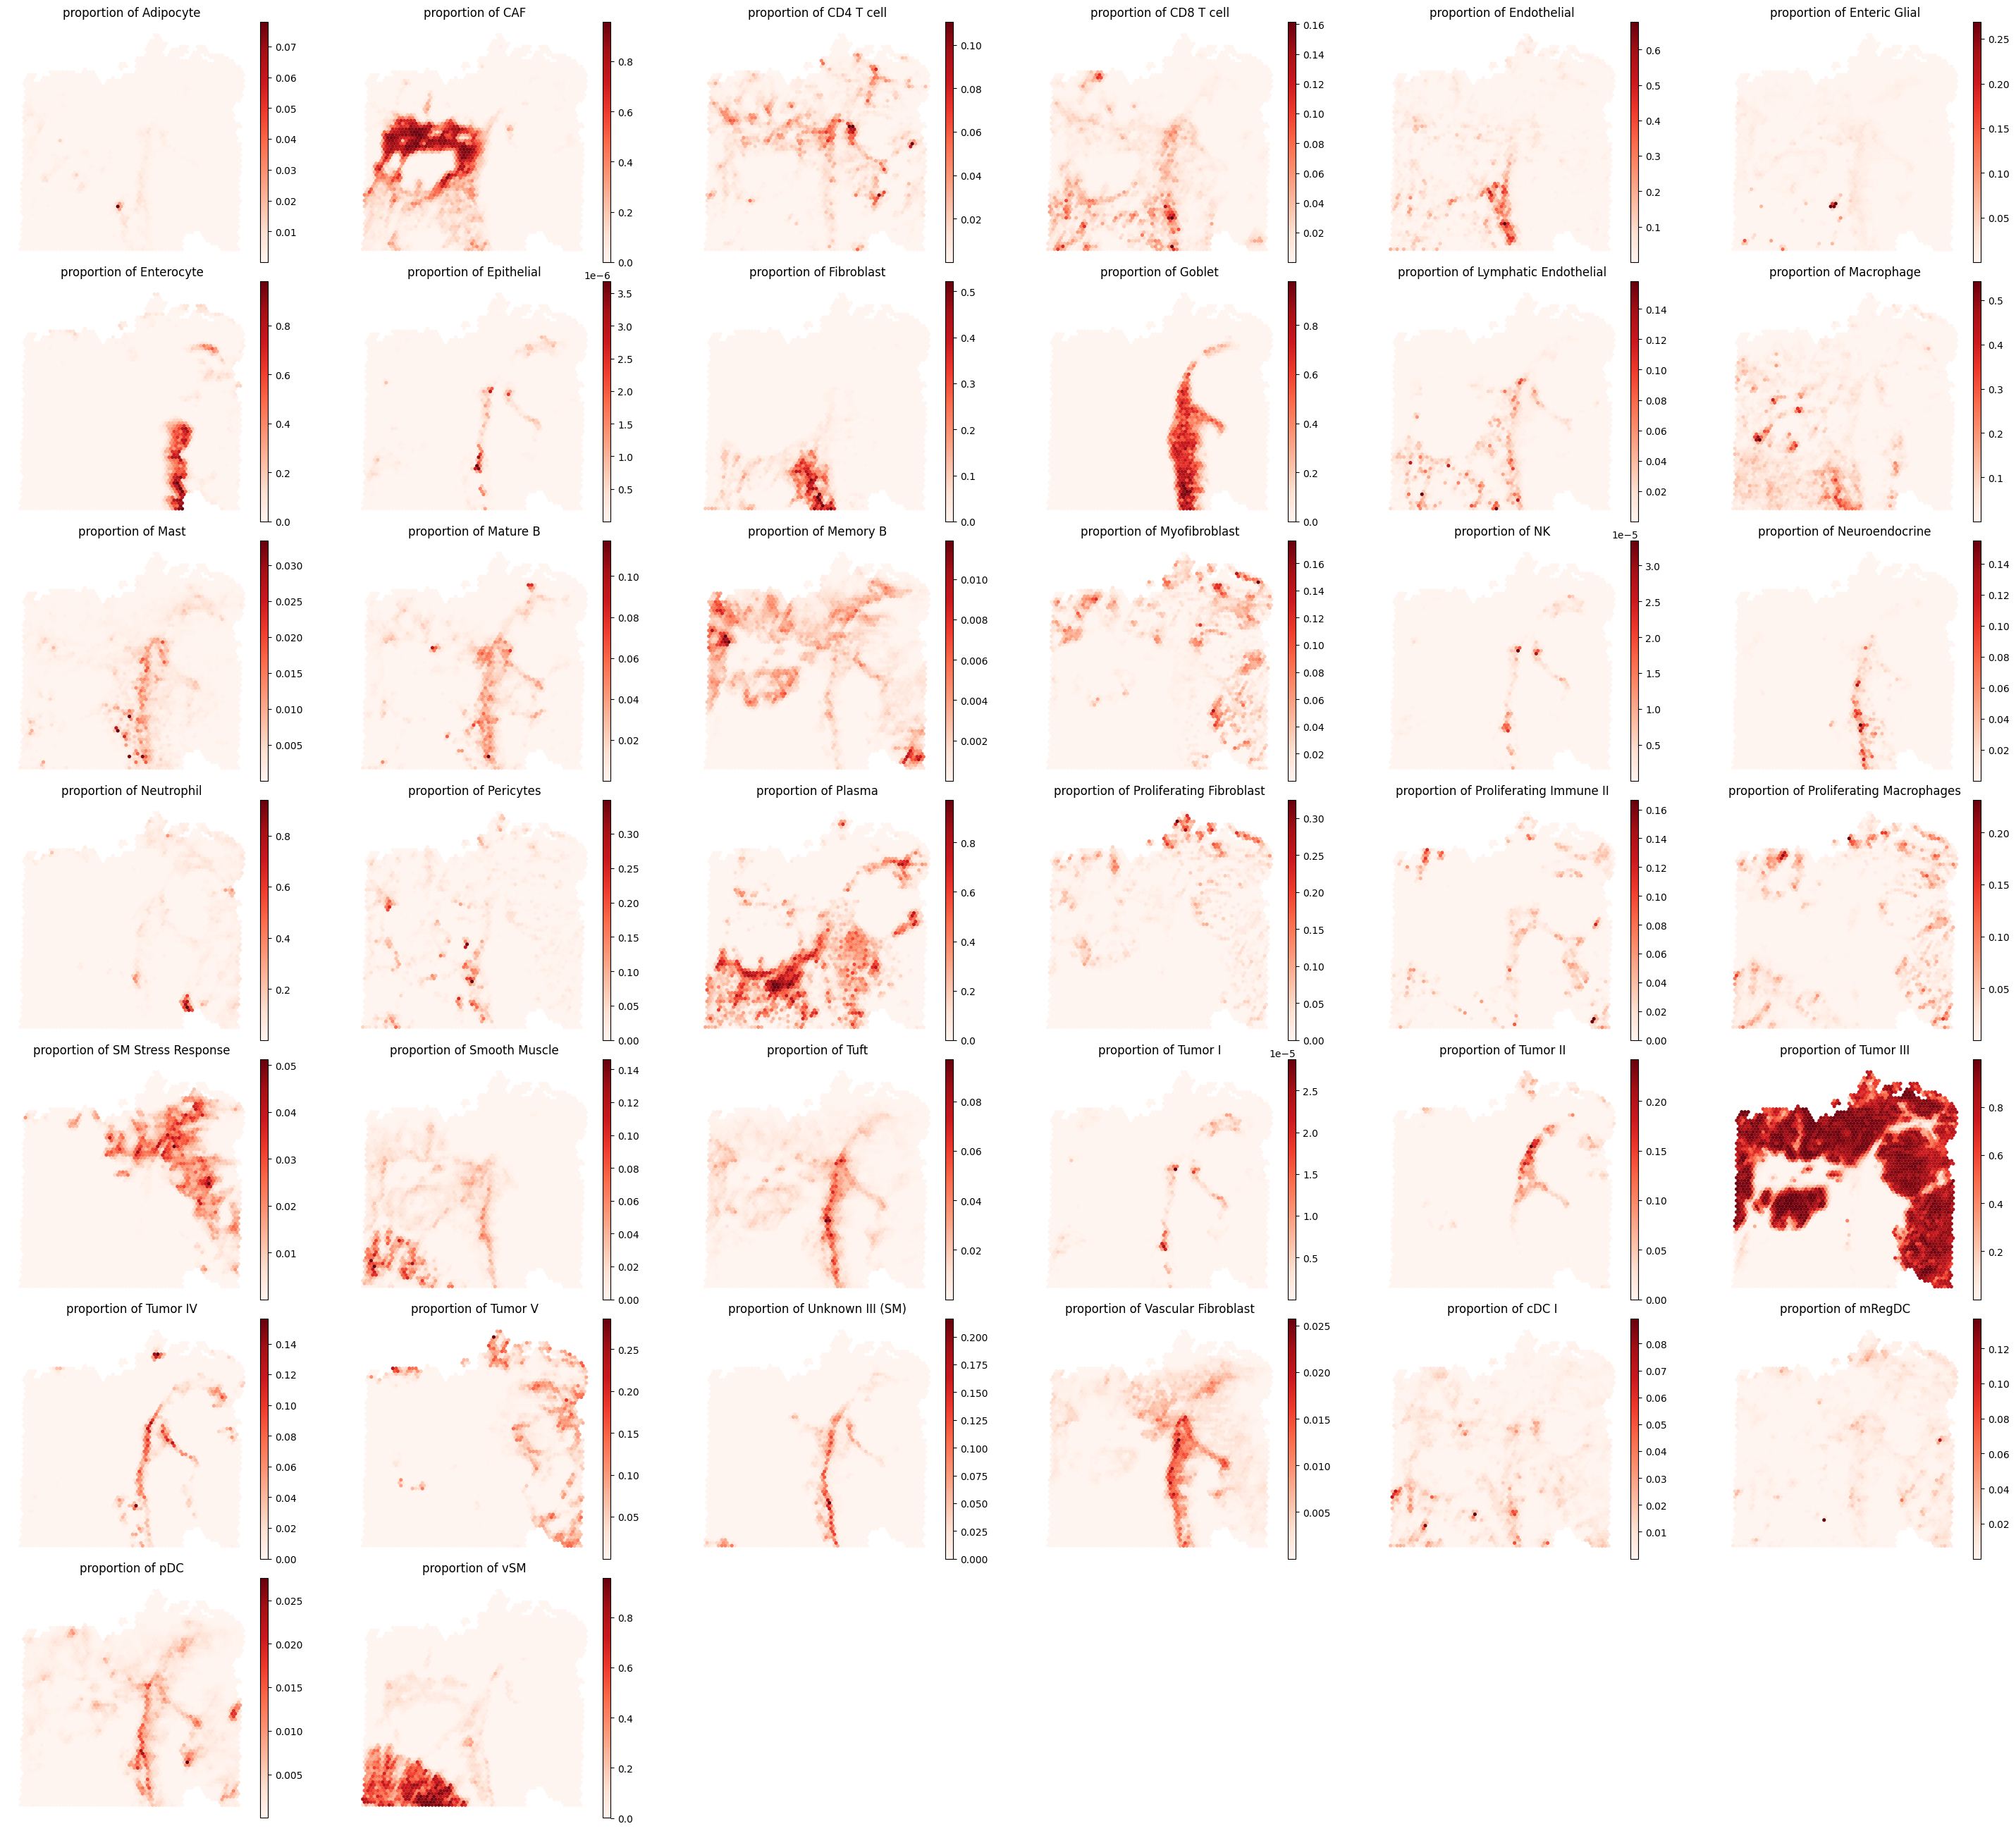

In [15]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion', hide_image=True, 
                proportion_threshold=0.0, num_threshold=100, 
                cmap='Reds', 
                spot_size=400, 
                ncols=6)

## Applying MacSGP to detect cell-type-specific SGPs

In [ ]:
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/CRC" # Raw data
SAVE_PATH = "/import/home2/share/yqzeng/MacSGP/results/CRC" # Deconvolution results
os.makedirs(os.path.join(SAVE_PATH), exist_ok = True)

In [ ]:
adata_st = ad.read_h5ad(os.path.join(DATA_PATH, "visium.h5ad"))
adata_basis = ad.read_h5ad(os.path.join(DATA_PATH, "visium_basis.h5ad"))

In [ ]:
filterd_ct = ['CAF', 'CD8 T cell', 'Endothelial', 'Enteric Glial', 'Enterocyte',
       'Fibroblast', 'Goblet', 'Lymphatic Endothelial', 'Macrophage', 'Mast',
       'Myofibroblast', 'Neuroendocrine', 'Neutrophil', 'Pericytes', 'Plasma',
       'Proliferating Fibroblast', 'Proliferating Immune II',
       'Proliferating Macrophages', 'Tuft', 'Tumor III', 'Tumor V', 'cDC I',
       'mRegDC', 'vSM']
adata_st.obsm['proportion'] = adata_st.obsm['proportion'][filterd_ct]
adata_basis = adata_basis[filterd_ct]

In [ ]:
model = MacSGP.model.Model(adata_st, adata_basis, n_layers=4, training_steps=3000, coef_reg=200/18, estimate_gamma=False, estimate_alpha=False)

model.train(step_interval=200)
adata_result = model.eval()

  0%|          | 6/3000 [00:00<01:46, 28.07it/s]

Step: 0, Loss: -98156.5312, d_loss: -98160.9062, f_loss: 43.7775, reg_loss: 0.0000


  7%|▋         | 204/3000 [00:07<01:38, 28.50it/s]

Step: 200, Loss: -98992.4453, d_loss: -99081.1016, f_loss: 13.3161, reg_loss: 7.8596


 14%|█▎        | 405/3000 [00:14<01:30, 28.56it/s]

Step: 400, Loss: -99199.7266, d_loss: -99278.5938, f_loss: 12.6393, reg_loss: 6.9841


 20%|██        | 606/3000 [00:21<01:23, 28.57it/s]

Step: 600, Loss: -99303.1094, d_loss: -99373.9219, f_loss: 12.1876, reg_loss: 6.2636


 27%|██▋       | 804/3000 [00:28<01:16, 28.59it/s]

Step: 800, Loss: -99362.3281, d_loss: -99434.1406, f_loss: 11.9735, reg_loss: 6.3554


 34%|███▎      | 1005/3000 [00:35<01:09, 28.62it/s]

Step: 1000, Loss: -99415.8516, d_loss: -99485.6250, f_loss: 11.7426, reg_loss: 6.1739


 40%|████      | 1206/3000 [00:42<01:02, 28.53it/s]

Step: 1200, Loss: -99449.0703, d_loss: -99521.3516, f_loss: 11.6380, reg_loss: 6.4004


 47%|████▋     | 1404/3000 [00:48<00:55, 28.63it/s]

Step: 1400, Loss: -99480.6719, d_loss: -99551.5859, f_loss: 11.4903, reg_loss: 6.2791


 54%|█████▎    | 1605/3000 [00:55<00:48, 28.62it/s]

Step: 1600, Loss: -99498.4531, d_loss: -99568.6328, f_loss: 11.4296, reg_loss: 6.2136


 60%|██████    | 1806/3000 [01:02<00:41, 28.60it/s]

Step: 1800, Loss: -99517.1250, d_loss: -99588.3672, f_loss: 11.3839, reg_loss: 6.3090


 67%|██████▋   | 2004/3000 [01:09<00:34, 28.60it/s]

Step: 2000, Loss: -99534.3984, d_loss: -99605.0234, f_loss: 11.2843, reg_loss: 6.2551


 74%|███████▎  | 2205/3000 [01:16<00:27, 28.59it/s]

Step: 2200, Loss: -99545.3906, d_loss: -99616.1094, f_loss: 11.2364, reg_loss: 6.2636


 80%|████████  | 2406/3000 [01:23<00:20, 28.61it/s]

Step: 2400, Loss: -99550.6953, d_loss: -99621.1797, f_loss: 11.2108, reg_loss: 6.2432


 87%|████████▋ | 2604/3000 [01:30<00:13, 28.63it/s]

Step: 2600, Loss: -99547.8438, d_loss: -99617.8828, f_loss: 11.6240, reg_loss: 6.1991


 94%|█████████▎| 2805/3000 [01:37<00:06, 28.60it/s]

Step: 2800, Loss: -99570.6875, d_loss: -99640.4141, f_loss: 11.0970, reg_loss: 6.1752


100%|██████████| 3000/3000 [01:44<00:00, 28.71it/s]


In [ ]:
adata_result.write_h5ad(os.path.join(SAVE_PATH, "visium.h5ad"))

Dropping cell types: ['Mast']


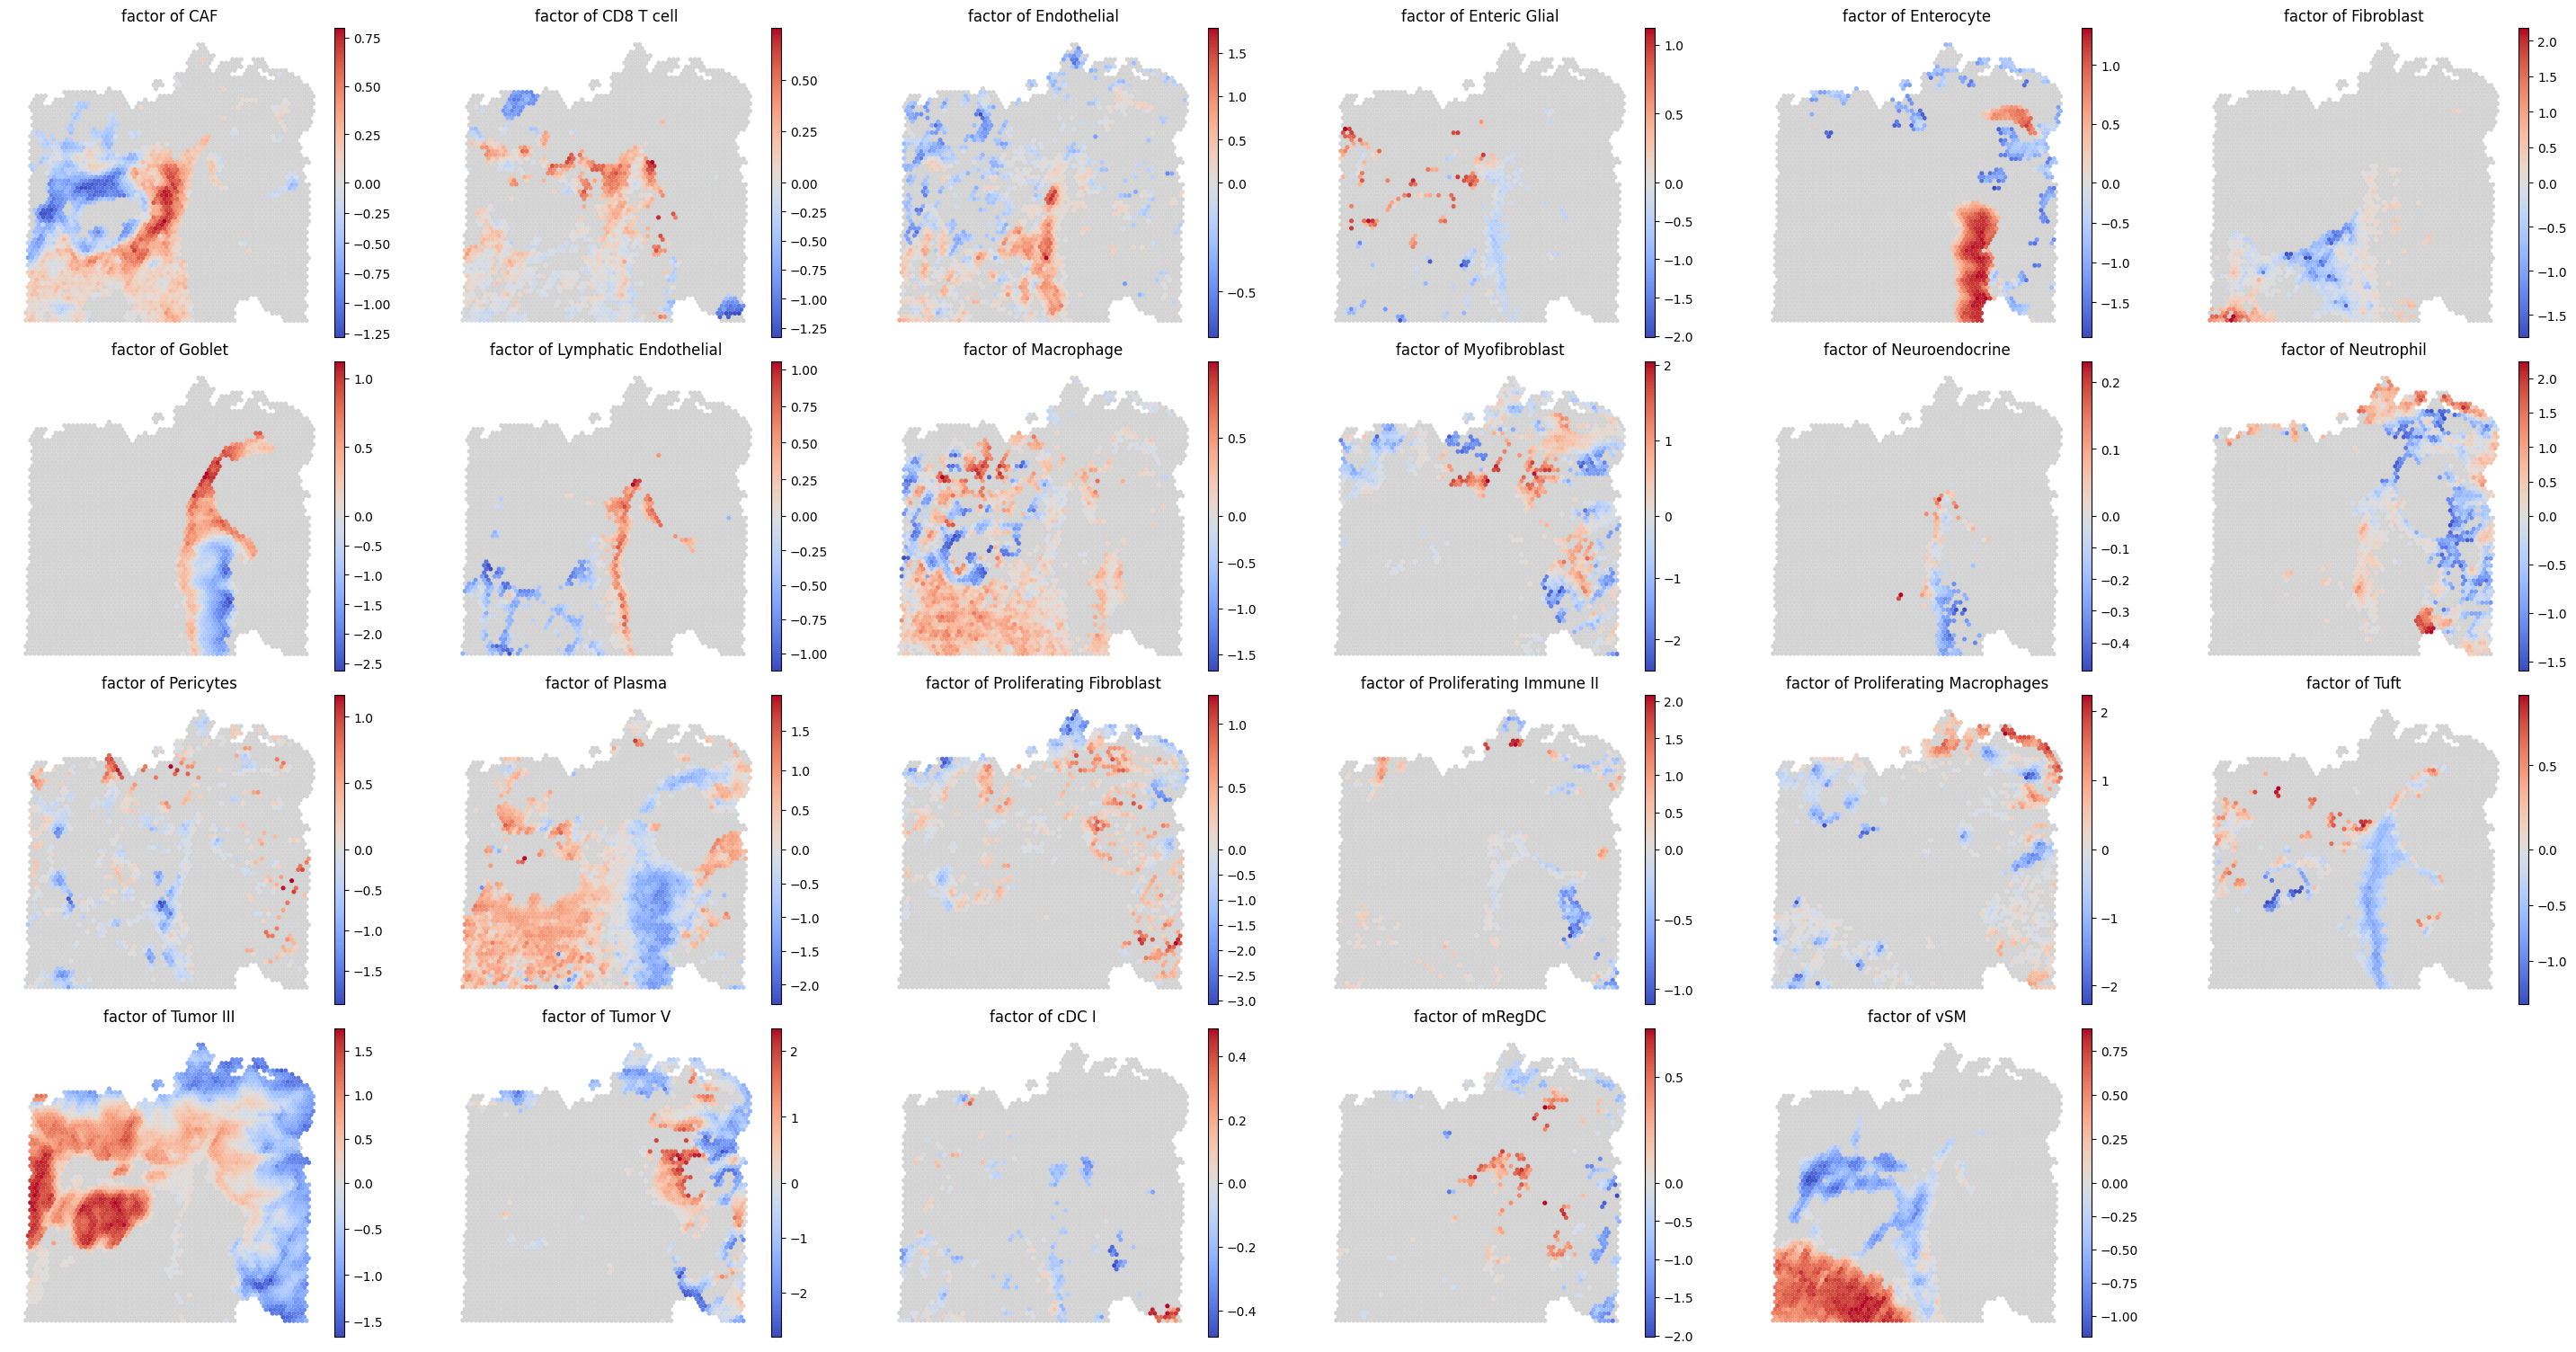

In [ ]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_result, index='factor', hide_image=True,
                proportion_threshold=0.01, num_threshold=100, 
                cmap='coolwarm', 
                spot_size=400, 
                ncols=6)